# Guilherme Cristiano Goll

# Informações do trabalho:
A base de dados que será utilizada nesse trabalho contém informações geológicas com etapas de pré-processamento já executadas.

Foi criada por um time de especialistas em litologia e contém informações de sensores e 11 classes a granulométricas na coluna “FORCE_2020_LITHOFACIES_LITHOLOGY”:
- 30000: Sandstone
- 65030: Sandstone/Shale
- 65000: Shale
- 80000: Marl
- 74000: Dolomite
- 70000: Limestone
- 70032: Chalk
- 88000: Halite
- 86000: Anhydrite
- 99000: Tuff
- 90000: Coal
- 93000: Basement

# Carregamento do dataset

Importação das bibliotecas que serão utilizadas neste experimento.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Configuração de exibição das colunas do dataframe, e utilização de um fator fixo (_seed_)para permitir a reprodução dos experimentos.

In [2]:
pd.set_option('display.max_columns', 90)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Carregamento do dataframe completo.

In [3]:
df_full = pd.read_csv('lithology.csv', sep=';' )

Informações gerais sobre o conjunto de dados.

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 31 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   DEPTH_MD                          1170511 non-null  float64
 1   X_LOC                             1170511 non-null  float64
 2   Y_LOC                             1170511 non-null  float64
 3   Z_LOC                             1170511 non-null  float64
 4   CALI                              1170511 non-null  float64
 5   RSHA                              1170511 non-null  float64
 6   RMED                              1170511 non-null  float64
 7   RDEP                              1170511 non-null  float64
 8   RHOB                              1170511 non-null  float64
 9   GR                                1170511 non-null  float64
 10  NPHI                              1170511 non-null  float64
 11  PEF                               117

In [5]:
df_full.FORCE_2020_LITHOFACIES_LITHOLOGY = df_full.FORCE_2020_LITHOFACIES_LITHOLOGY.astype(int)

In [6]:
df_full.corr()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,FORCE_2020_LITHOFACIES_LITHOLOGY,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
DEPTH_MD,1.000000,-0.081904,0.249745,-0.987890,0.242287,0.072961,0.055864,0.062862,0.267399,0.098282,0.414375,0.201044,0.086242,-0.212204,-0.618097,-0.031847,0.253296,0.249273,-0.182790,0.146459,-0.007422,0.252801,0.267160,0.044830,0.215984,0.266868,0.000432,0.002445,0.266868,0.056807,-0.293998
X_LOC,-0.081904,1.000000,0.416875,0.085877,-0.249819,-0.164608,-0.044303,0.054780,0.098533,0.231190,0.089433,-0.035485,-0.076769,-0.121053,-0.092630,-0.078123,-0.215753,0.055254,-0.333802,0.223622,-0.019755,0.096850,0.098485,0.167773,-0.071248,0.098435,-0.000287,0.000974,0.098434,0.094923,-0.225151
Y_LOC,0.249745,0.416875,1.000000,-0.259623,-0.148181,-0.175650,0.109941,0.009231,0.106056,0.206453,0.068874,0.071257,0.030885,-0.076501,-0.167017,-0.274776,-0.143624,0.090255,-0.738548,0.059190,-0.034079,0.102346,0.105965,0.131760,0.047832,0.105851,-0.000184,0.002194,0.105851,0.024585,-0.163860
Z_LOC,-0.987890,0.085877,-0.259623,1.000000,-0.234391,-0.088610,-0.087831,-0.111010,-0.277483,-0.101529,-0.411152,-0.197759,-0.081243,0.174611,0.615375,0.038685,-0.245064,-0.256565,0.193531,-0.150293,0.019270,-0.262971,-0.277247,-0.043703,-0.208389,-0.276951,-0.000414,-0.002509,-0.276951,-0.044176,0.291771
CALI,0.242287,-0.249819,-0.148181,-0.234391,1.000000,0.230859,0.200187,0.059856,0.290623,-0.131479,0.159466,0.253697,0.336849,0.117929,-0.093683,0.061482,0.911076,0.281891,0.172453,0.095982,-0.038173,0.288104,0.290592,-0.133204,0.394364,0.290467,0.000167,0.000338,0.290466,0.055227,0.017484
RSHA,0.072961,-0.164608,-0.175650,-0.088610,0.230859,1.000000,0.038447,0.041122,0.113860,-0.043932,0.108301,-0.048833,0.068859,0.262062,-0.077242,-0.000514,0.211634,0.083668,0.202040,0.166244,-0.041135,0.112537,0.113915,-0.063521,0.088760,0.113818,-0.000398,-0.001663,0.113820,-0.011004,0.001706
RMED,0.055864,-0.044303,0.109941,-0.087831,0.200187,0.038447,1.000000,0.093780,0.204210,0.117150,0.087206,0.196880,0.354425,0.248956,-0.084409,-0.014198,0.178310,0.172003,-0.063313,0.075098,-0.083413,0.204782,0.204219,0.087406,0.350722,0.204328,0.001224,0.000175,0.204323,-0.031007,-0.022347
RDEP,0.062862,0.054780,0.009231,-0.111010,0.059856,0.041122,0.093780,1.000000,0.113988,0.009550,0.086625,0.014515,0.076234,0.023633,-0.049338,0.004839,0.055512,0.106038,0.003755,0.022012,0.009211,0.114447,0.113994,0.003944,0.090665,0.114003,0.000662,0.000325,0.114004,0.045048,-0.006239
RHOB,0.267399,0.098533,0.106056,-0.277483,0.290623,0.113860,0.204210,0.113988,1.000000,-0.002582,0.474023,0.458521,0.424886,0.074638,-0.336723,-0.058474,0.291568,0.882447,-0.062072,0.084565,-0.023634,0.999727,1.000000,-0.062674,0.462418,0.999583,0.000408,0.000908,0.999579,0.022361,-0.127749
GR,0.098282,0.231190,0.206453,-0.101529,-0.131479,-0.043932,0.117150,0.009550,-0.002582,1.000000,0.169099,0.049547,-0.077324,-0.161919,-0.182325,0.034934,-0.093328,-0.026357,-0.119144,0.153378,0.163939,-0.006083,-0.002662,0.583831,-0.074397,-0.002677,-0.051292,-0.000304,-0.002682,0.062451,-0.172180


Analisando a tabela de correlação entre as colunas do dataset acima, nota-se uma forte relação entre algumas delas.

Aparentemente, as variáveis abaixo tratam-se da mesma informação, que passou por alguma regra de normalização linear e que são reforçadas pela relação entre o nome destas variáveis:
- RHOB x Delta_RHOB x Normalized_RHOB
- Carbon_Index x Delta_Carbon_Index
- DTC x Delta_DTC

Por este motivo, as colunas originais e/ou normalizadas serão desconsideradas deste experimento, a fim de reduzir a complexidade do modelo. Logo, Entre as variáveis listadas acima, serão mantidas apenas: `Delta_RHOB`, `Delta_Carbon_Index` e `Delta_DTC`.

Outra colunas, como `GR` e `DEPTH_MD`, que têm outras variáveis com um nome corresponde `Normalized_` e `Delta_`, respectivamente, não apresentaram correlação direta. Portanto, serão mantidas neste experimento.

In [7]:
df = df_full
df.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,FORCE_2020_LITHOFACIES_LITHOLOGY,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
count,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,2.184087e+03,4.856292e+05,6.679845e+06,-2.128037e+03,-6.280493e+01,-4.549949e+02,-2.845864e+01,1.189409e+00,-1.356686e+02,7.091370e+01,-3.455267e+02,-4.221022e+02,7.842011e+01,-2.171530e+02,1.187501e+01,-4.795367e+02,-8.728321e+01,-1.612117e+02,-7.288450e+02,-8.474787e+02,6.138598e+04,-1.279143e+02,-1.371562e+02,2.641028e-01,-3.303349e+01,-1.377378e+02,-7.344170e-04,1.530734e-01,-1.377387e+02,6.627583e+00,4.129572e+01
std,9.971821e+02,3.445166e+04,1.290797e+05,9.725712e+02,2.667498e+02,5.087190e+02,1.880157e+02,1.495506e+02,3.451085e+02,3.423149e+01,4.754047e+02,4.972170e+02,2.045332e+02,4.701992e+02,3.052529e+00,1.184783e+03,2.841910e+02,3.675140e+02,4.441372e+02,3.616692e+02,1.389170e+04,3.482977e+02,3.445138e+02,1.806016e-01,1.786926e+02,3.444248e+02,3.516985e+00,3.212288e-01,3.444257e+02,3.125934e+00,2.282790e+01
min,1.360860e+02,4.268988e+05,6.406641e+06,-5.395563e+03,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,1.092843e-01,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,6.000000e+00,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,3.000000e+04,-9.990000e+02,-9.990000e+02,0.000000e+00,-9.990000e+02,-9.990000e+02,-2.685117e+02,0.000000e+00,-9.990000e+02,0.000000e+00,-1.000000e+00
25%,1.418597e+03,4.548018e+05,6.591140e+06,-2.804552e+03,8.874150e+00,-9.990000e+02,8.711777e-01,8.963877e-01,2.000454e+00,4.762722e+01,-9.990000e+02,-9.990000e+02,8.526329e+01,-9.990000e+02,8.500000e+00,-9.990000e+02,-5.335999e-02,-2.112656e-02,-9.990000e+02,-9.990000e+02,6.500000e+04,2.852751e+00,3.509227e-01,1.209661e-01,-7.185020e-01,-1.644254e-02,-1.380630e+00,1.520000e-01,-5.005838e-01,5.000000e+00,2.400000e+01
50%,2.076605e+03,4.769078e+05,6.732205e+06,-2.030516e+03,1.242991e+01,5.516068e-01,1.400712e+00,1.428157e+00,2.243782e+00,6.836763e+01,2.352654e-01,2.899809e+00,1.069366e+02,4.044000e+01,1.225000e+01,-9.990000e+02,3.736696e-01,-2.317054e-03,-9.990000e+02,-9.990000e+02,6.500000e+04,7.653391e+00,5.256773e-01,2.238263e-01,-1.633453e-02,-2.060652e-03,-1.548767e-03,1.520000e-01,-6.042549e-02,6.000000e+00,3.900000e+01
75%,2.864393e+03,5.201532e+05,6.784878e+06,-1.373344e+03,1.574931e+01,1.510922e+00,2.587100e+00,2.537876e+00,2.462978e+00,8.903551e+01,3.653732e-01,4.619021e+00,1.401350e+02,7.039606e+01,1.225000e+01,1.502688e+01,1.693081e+00,1.489764e-02,1.330073e-01,-9.990000e+02,6.500000e+04,1.550824e+01,6.792460e-01,3.778281e-01,5.912170e-01,5.912662e-03,1.371843e+00,1.520000e-01,1.740417e-01,9.000000e+00,6.600000e+01
max,5.436632e+03,5.726328e+05,6.856661e+06,-1.110860e+02,2.827900e+01,2.193905e+03,1.988616e+03,1.999887e+03,3.457820e+00,1.076964e+03,9.995703e-01,3.831300e+02,1.555313e+03,5.265473e+02,2.600000e+01,4.701512e+04,7.999847e+00,1.467912e+00,1.857309e+02,1.000000e+04,9.900000e+04,1.570291e+02,1.000000e+00,1.000000e+00,7.596500e+02,1.120613e+00,2.665444e+02,2.693440e+02,1.107053e+02,1.300000e+01,6.900000e+01


In [8]:
print('Quantidade de classes presentes neste dataset:', len(df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()))

Quantidade de classes presentes neste dataset: 12


In [9]:
def distribution(df, column, title_sufix: str=None):
    '''
    Plota a distribuição da coluna em um gráfico de barras horizontal.
    '''
    fig, ax = plt.subplots(figsize=(16,9))
    grouped = df[column].value_counts().sort_values(ascending=True)

    df_grouped = grouped.to_frame()
    df_grouped.reset_index(level=0, inplace=True)
    df_grouped.columns = ['item', 'count']
    labels = df_grouped['item'].astype(str)
    values = df_grouped['count']

    ax.clear()
    ax.barh(labels, values, alpha=0.75)
    for i, (value, name) in enumerate(zip(values, labels)):
        ax.text(value, i, value, size=12, ha='left', va='center')

    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.margins(0.003, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    title = 'Distribuição de classes'
    if title_sufix is not None:
        title = f'{title} no conjunto de {title_sufix}'
        
    ax.set_title(title)

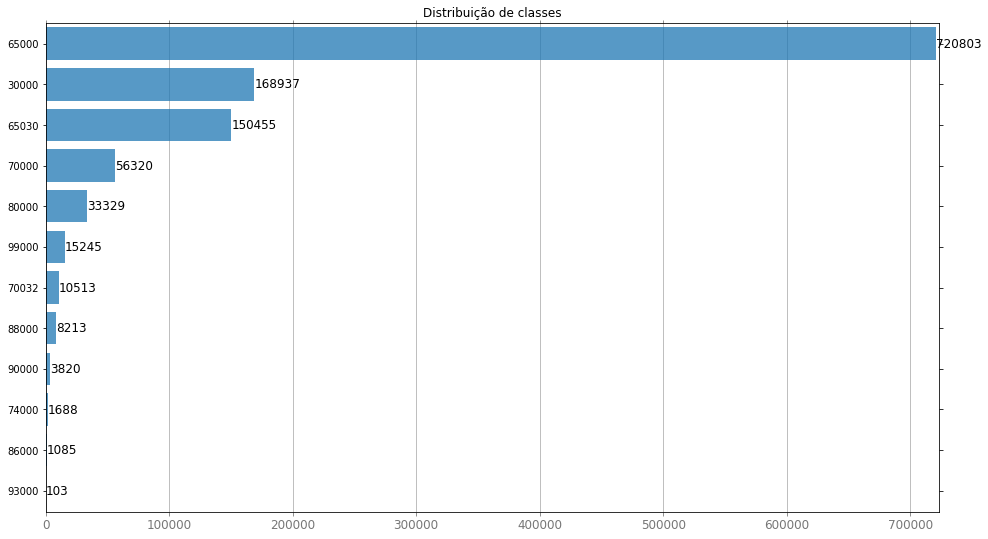

In [10]:
distribution(df, 'FORCE_2020_LITHOFACIES_LITHOLOGY')

Através do gráfico acima nota-se um forte desbalanceamento no conjunto de dados, com uma classe predominante (`65000`).

## Separação do dataset entre as variáveis preditoras `X` e variável predita `y`

In [11]:
X = df
y = df.pop('FORCE_2020_LITHOFACIES_LITHOLOGY')

## Extração das features do dataset

Para as colunas preditoras, os encoders utilizados serão armazenados em memória para reutilização na leitura e processamento do dataset `hidden`.

Neste momento é que descartaremos as variáveis que apresentam diferentes manipulações delas mesmas, mencionadas anteriormente.

**IMPORTANTE**: A variável categórica `FORMATION_encoded`, no conjunto de treino (`lithology.csv`) não contém o valor `12` em seu range de valores válidos, enquanto no conjunto `hidden.csv` ela existe. Consequentemente, não é possível, apenas considerando os dados do conjunto de treino fornecido, codificar apropriadamente esta variável. Seria tecnicamente possível, através de _data augmentation_, por exemplo, criar alguns registros _fakes_ no conjunto de treino, com o valor 12, para assim treinar o _encoder_ de modo a suportar este valor no conjunto `hidden.csv`. No entanto, isto provavelmente serviria apenas para "iludir" o modelo, uma vez que são dados oriundos de outros tipos de rochas. Portanto, esta variável não será utilizada neste experimento.

In [12]:
mms = MinMaxScaler()
mms_columns = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
               'GR', 'NPHI', 'PEF', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 
               'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD',
               'Delta_Carbon_Index']

ohe = OneHotEncoder(sparse=False)
ohe_columns = ['GROUP_encoded']

le = LabelEncoder()

def return_features(X_train, X_test, y_train, y_test):
    '''Este método realiza os encodes necessários nas variáveis preditoras e predita
    para que o modelo de rede neural possa interpretá-los adequadamente.
    Neste caso são utilizados três encoders:
    - OneHotEncoder - para variáveis categóricas nos conjuntos de variáveis preditoras
    - MinMaxScaler - para variáveis contínuas nos conjuntos de variáveis preditoras
    - LabelEncoder - para variáveis categóricas nos conjuntos da variável predita
    '''    
    
    X_train_mms = mms.fit_transform(X_train[mms_columns])
    X_test_mms = mms.transform(X_test[mms_columns])    
    
    X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
    X_test_ohe = ohe.transform(X_test[ohe_columns])
    
    X_train_processed = np.hstack([X_train_ohe, X_train_mms])
    X_test_processed = np.hstack([X_test_ohe, X_test_mms])
    
    y_train_le = le.fit_transform(y_train)
    y_test_le = le.transform(y_test)
    
    return X_train_processed, X_test_processed, y_train_le, y_test_le

In [13]:
def get_labelencoder_mapping(le):
    '''
    Retorna um dicionário das labels mapeadas pelo LabelEncoder informado, linkadas ao seu código/ inteiro.
    Isto permite que tenhamos a 'descrição' da classe, informando seu código.
    '''
    res = {}
    for cl in le.classes_:
        res.update({le.transform([cl])[0]:cl})

    return res

## Divisão do conjunto entre treino, teste e validação

O conjunto de treino será dividido em três sub-conjuntos:
- Treino: com (por padrão) 70% do volume total de registros.
- Teste: com (por padrão) 75% dos 30% de dados restantes (após a divisão de treino) totalizando aproximadamente 22,5% do conjunto total.
- Validação: com (por padrão) 25% dos 30% dos dados restantes (após a divisão de treino) totalizando aproximadamente 7,5% do conjunto total.

In [14]:
def train_test_val_split(X, y, train_size=0.7, valid_size=0.25):
    '''Divisão do dataset de treino, teste e validação.
    -> train_size: proporção do conjunto de treino em relação ao dataset completo
    -> valid_size: proporção do conjunto de validação em relação ao dataset de teste 
    (diferença entre o dataset completo e o de treino)
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=42, )
    X_train, X_test, y_train, y_test = return_features(X_train, X_test, y_train, y_test)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=valid_size, shuffle=True, random_state=42)
    return X_train, X_test, X_val, y_train, y_test, y_val

In [15]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, y, train_size=0.7, valid_size=0.25)

## Visualização da distribuição de classes nos subconjuntos

A visualização ajuda a identificar se a distribuição entre estes subconjuntos está minimamente similar à distribuição do conjunto de treino.

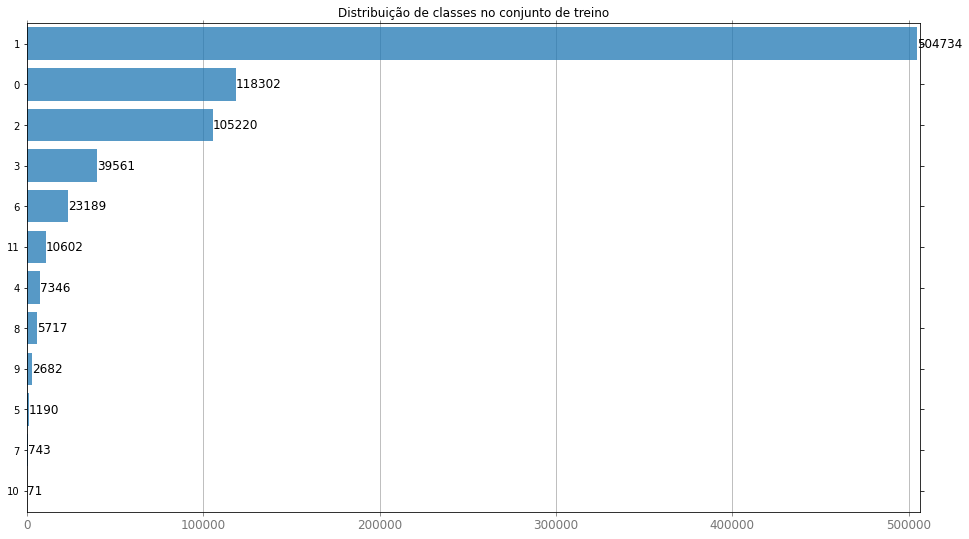

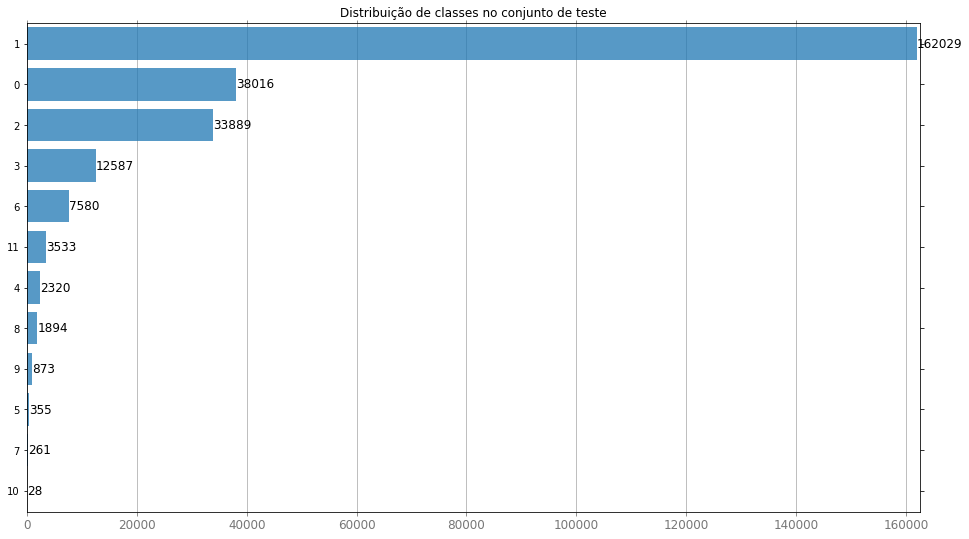

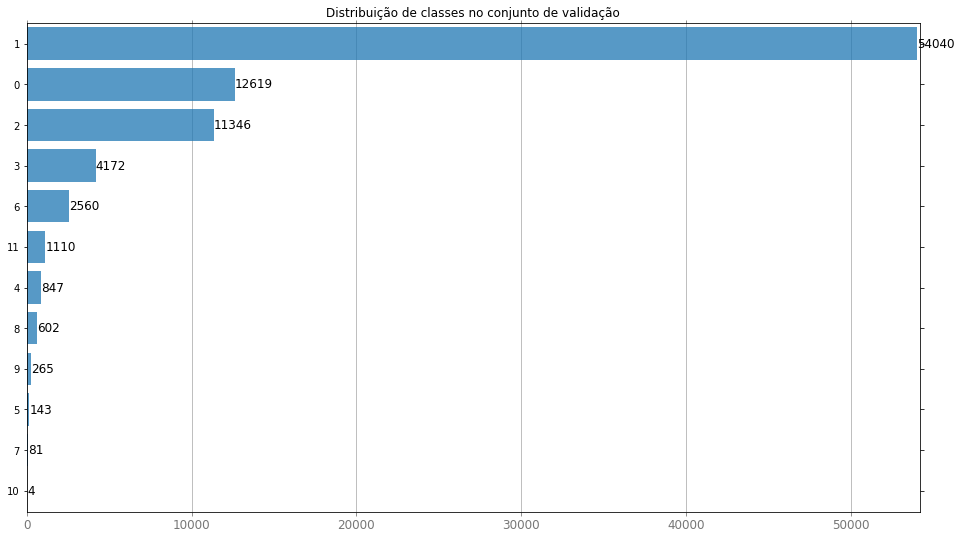

In [16]:
df_y_train = pd.DataFrame(y_train, columns=['Classe'])
distribution(df_y_train, 'Classe', 'treino')
df_y_test = pd.DataFrame(y_test, columns=['Classe'])
distribution(df_y_test, 'Classe', 'teste')
df_y_val = pd.DataFrame(y_val, columns=['Classe'])
distribution(df_y_val, 'Classe', 'validação')

# Redes neurais

A partir daqui serão explorados alguns algoritmos de redes neurais para solução do problema acima.

Configuração para execução com a GPU, quando disponível.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

A seguir são apresentadas três classes de redes neurais.

- ``LogisticRegression`` trata-se de uma regressão logística simples, ou seja, contendo apenas uma camada linear de ativação.
- ``Perceptron`` trata-se de uma evolução da regressão logística. Além da camada de ativação linear, há também uma camada do tipo `ReLu`.
- ``MultiLayer`` trata-se de uma rede neural multi camadas. Além dos parâmetros de entrada (`n_input`) e saída (`n_output`), é possível também definir a saída entrada entre as camadas internas (`n_hidden_size`).

Todas as classes acima contam com o processo de retroalimentação, ou `backpropagation`, implementados automaticamente pelo Pytorch a partir do método `forward()`.

In [18]:
class LogisticRegression(nn.Module):
    def __init__(self, n_input, n_output):
        super(LogisticRegression, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)

    def forward(self, x):
        outputs = self.Linear(x)
        return outputs
    
    def model_name(self):
        return 'Logistic Regression'

class Perceptron(torch.nn.Module):
    def __init__(self, n_input, n_output):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(n_input, n_output)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        output = self.fc(x)
        output = self.relu(x)
        return output
    
    def model_name(self):
        return 'Perceptron'

class MultiLayer(torch.nn.Module):
    def __init__(self, n_input, n_hidden_size, n_output, n_dropout=0.0):
        super(MultiLayer, self).__init__()
        self.input_size = n_input
        self.hidden_size  = n_hidden_size
        self.output_size = n_output
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.dropout = nn.Dropout(n_dropout)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()        
    
    def forward(self, x):
        hidden = self.fc1(x)
        dropout = self.dropout(hidden)
        relu = self.relu(dropout)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output
    
    def model_name(self):
        return 'Multi Layer'

Conversão dos conjuntos de treino, teste e validação em ``torch.tensor`` para utilização por parte do PyTorch.

In [19]:
X_train, y_train, X_test,  y_test, = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

X_val, y_val = map(
torch.tensor, (X_val, y_val))

Abaixo são definidos alguns parâmetros gerais:
- `input_size`: dimensão dos dados na camada de entrada do modelo.
- `output_size`: dimensão de saída dos dados, representado pela quantidade de classes disponíveis para classificação.
- `bs`: batch size.

In [20]:
input_size = X_train.shape[1]
output_size = len(y.unique())
bs = 256 #batch size

A seguir são criados conjuntos do tipo `DataLoader`, que é uma abstração do PyTorch. Isto facilitará as iterações (épocas) sobre os modelos.
Além disso, ele facilita a utilização do batch size.

In [21]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, )
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)
valid_ds = TensorDataset(X_val, y_val)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [22]:
def choose_nn_model(model_name: str, 
                    device, 
                    learning_rate,
                    input_size: int = 0,
                    output_size: int = 0,
                    dropout: float = 0.0,
                    hidden: int = 1,
                    optimizer: str = 'SGD',
                    momentum: float = 0.0,
                    weight_decay: float = 0.0,
                    ):
    '''
    Identificar e retorna o modelo e o otimizador que será utilizado.
    
    Args:
        model_name: nome do modelo. Suporte à: 'logisticregression', 'perceptron', 'multilayer'.
        device: dispositivo em que será executado o processamento ('cpu' ou 'cuda').
        learning_rate: taxa de aprendizado a ser adotada pelo otimizador.
        input_size: dimensão dos dados na camada de entrada do modelo.
        output_size: dimensão dos dados na camada de saída do modelo (quantidade de classes).
        dropout: taxa de dropout que será utilizada entre certas camadas do modelo.
        hidden: tamanho da quantidade de camadas ocultas.
        optimizer: otimizador que será adotado para ajuste dos pesos. Suporte à: 'SGD', 'Adam', 'AdamW', 'ASGD'.
        momentum: fator momentum. É utilizado apenas pelo otimizador SGD.
        weight_decay: taxa adotada pelo regularizador L2 para aplicação no modelo. Utilizado apenas nos 
        otimizadores Adam e derivados.
    '''
    model = None
    opt = None
    
    if model_name == 'logisticregression':
        model = LogisticRegression(input_size, output_size)
    elif model_name == 'perceptron':
        model = Perceptron(input_size, output_size)
    elif model_name == 'multilayer':
        model = MultiLayer(input_size, hidden, output_size, dropout)
        
    opt = choose_optimizer(optimizer, learning_rate, model, momentum, weight_decay)
    
    if model is not None:
        model.double()
        
    return model, opt

def choose_optimizer(optimizer: str, learning_rate, model, momentum: float=0.0, weight_decay: float=0.0):
    if model is None:
        return
    
    opt = None
    
    if optimizer == 'SGD':
        opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer == 'Adam':
        opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'AdamW':
        opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'ASGD':
        opt = optim.ASGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    return opt        

In [1]:
def loss_batch(model, device, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)
    loss = criterion(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def valid_batch(model, device, xb, yb):
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)
    loss = criterion(output, yb)
    pred = torch.argmax(output, dim=1)
    correct = pred == yb.view(*pred.shape)

    return loss.item(), torch.sum(correct).item(), len(xb)

In [24]:
def fit(model, opt, epochs, train_dl, test_dl, device):
    print(f'\nExecutando o classificador: {model}')
    
    scheduler = None
    if opt is not None:
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
        
    for epoch in range(epochs):
        print(f'Iniciando época {epoch + 1}/{epochs}')
        model.train()
        losses, nums = zip(
            *[loss_batch(model, device, xb, yb, opt) for xb, yb in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(
                *[valid_batch(model, device, xb, yb) for xb, yb in test_dl]
            )      
            
            test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            test_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"- Train loss: {train_loss:.6f}\t",
                  f"Test loss: {test_loss:.6f}\t",
                  f"Test accuracy: {test_accuracy:.3f}%")
        
        if opt is None:
            print('Não há otimizador para este modelo. Loop de épocas será interrompido.')
            return model
        
        scheduler.step()
    
    
    return model

### Definição de parâmetros gerais

A seguir são definidos os parâmetros gerais utilizados pelos modelos.
- O `lr` é o _learning rate_.
- O `epochs` representa a quantidade de épocas ou iterações que serão executadas para treino do modelo.
- O `momentum` é um parâmetro exclusivo para o otimizador do tipo SGD (Stochastic Gradient Descent).
- O `l2_reg` é taxa de regularização ou penalização L2.
- O `dropout` é autoexplicativo.

In [25]:
lr = 0.01
epochs = 50
momentum = 0.9
l2_reg = 0.001
dropout = 0.5

Abaixo são definidos os modelos com os respectivos parâmetros. Eles foram organizados de acordo com o otimizador,

In [26]:
models = []

models.append(choose_nn_model('perceptron', device, lr, input_size, output_size, optimizer = None))

models.append(choose_nn_model('logisticregression', device, lr, input_size, output_size, optimizer = 'SGD', momentum=momentum, weight_decay=l2_reg))
models.append(choose_nn_model('logisticregression', device, lr, input_size, output_size, optimizer = 'SGD', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, optimizer = 'SGD', momentum=momentum, weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, optimizer = 'SGD', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, optimizer = 'SGD'))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, optimizer = 'SGD', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, hidden=3, optimizer = 'SGD', weight_decay=l2_reg))

models.append(choose_nn_model('logisticregression', device, lr, input_size, output_size, optimizer = 'Adam', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, optimizer = 'Adam'))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, optimizer = 'Adam', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, optimizer = 'Adam', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, hidden=3, optimizer = 'Adam', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, optimizer = 'Adam'))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, optimizer = 'Adam'))

models.append(choose_nn_model('logisticregression', device, lr, input_size, output_size, optimizer = 'AdamW', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, optimizer = 'AdamW', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, hidden=3, optimizer = 'AdamW', weight_decay=l2_reg))

models.append(choose_nn_model('logisticregression', device, lr, input_size, output_size, optimizer = 'ASGD', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, optimizer = 'ASGD', weight_decay=l2_reg))
models.append(choose_nn_model('multilayer', device, lr, input_size, output_size, dropout=dropout, hidden=3, optimizer = 'ASGD', weight_decay=l2_reg))

Definição da função de custo. Além da função utilizada `F.cross_entropy` também é possível utilizar a função `F.multi_margin_loss`, sem que seja necessário efetuar quaisquer modificações nos modelos.

In [27]:
criterion = F.cross_entropy
#criterion = F.multi_margin_loss

In [28]:
fitted_models = []

for model, opt in models:
    model.to(device)
    new_model = fit(model, opt, epochs, train_dl, test_dl, device)
    fitted_models.append(new_model)


Executando o classificador: Perceptron(
  (fc): Linear(in_features=38, out_features=12, bias=True)
  (relu): ReLU()
)
Iniciando época 1/50
- Train loss: 3.998804	 Test loss: 3.998864	 Test accuracy: 2.019%
Não há otimizador para este modelo. Loop de épocas será interrompido.

Executando o classificador: LogisticRegression(
  (Linear): Linear(in_features=38, out_features=12, bias=True)
)
Iniciando época 1/50
- Train loss: 0.996642	 Test loss: 0.916486	 Test accuracy: 67.433%
Iniciando época 2/50
- Train loss: 0.899231	 Test loss: 0.888444	 Test accuracy: 68.410%
Iniciando época 3/50
- Train loss: 0.883070	 Test loss: 0.878692	 Test accuracy: 68.640%
Iniciando época 4/50
- Train loss: 0.876543	 Test loss: 0.874489	 Test accuracy: 68.871%
Iniciando época 5/50
- Train loss: 0.873256	 Test loss: 0.871973	 Test accuracy: 68.891%
Iniciando época 6/50
- Train loss: 0.871458	 Test loss: 0.870782	 Test accuracy: 69.041%
Iniciando época 7/50
- Train loss: 0.870311	 Test loss: 0.869920	 Test accu

## Validação do modelo

Após executar os modelos e aferi-los com o conjunto de treino e testes, chegou a hora de aplicá-lo sobre o conjunto de validação.

Para isto serão utilizados os modelos já treinados inseridos no ``fitted_models``.

Para cada modelo treinado, o conjunto de validação será executado e avaliado.

Ao final, apenas o melhor modelo 

In [29]:
def validate(model, device, dataloader):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(
            *[valid_batch(model, device, xb, yb) for xb, yb in dataloader]
        )      
        
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_accuracy = np.sum(corrects) / np.sum(nums) * 100
        print(f'Modelo {model.model_name()}\t',
              f'Loss: {val_loss:.6f}\t',
              f'Acurácia: {val_accuracy:3f}')
        return val_accuracy

In [30]:
models_score = []
for model in fitted_models:
    print(model)
    acc = validate(model, device, valid_dl)
    models_score.append([model, acc])

Perceptron(
  (fc): Linear(in_features=38, out_features=12, bias=True)
  (relu): ReLU()
)
Modelo Perceptron	 Loss: 3.998781	 Acurácia: 2.017337
LogisticRegression(
  (Linear): Linear(in_features=38, out_features=12, bias=True)
)
Modelo Logistic Regression	 Loss: 0.866127	 Acurácia: 69.171536
LogisticRegression(
  (Linear): Linear(in_features=38, out_features=12, bias=True)
)
Modelo Logistic Regression	 Loss: 0.886835	 Acurácia: 68.215836
MultiLayer(
  (fc1): Linear(in_features=38, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=1, out_features=12, bias=True)
  (sigmoid): Sigmoid()
)
Modelo Multi Layer	 Loss: 1.920775	 Acurácia: 61.557826
MultiLayer(
  (fc1): Linear(in_features=38, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=1, out_features=12, bias=True)
  (sigmoid): Sigmoid()
)
Modelo Multi Layer	 Loss: 1.984115	 Acurácia: 61.556687
MultiLayer(
  (f

In [31]:
best_model = [None, 0]
for i, model in enumerate(models_score):
    # Se a acurácia for superior, será o escolhido
    if model[1] > best_model[1]:
        best_model = model

In [32]:
#Seleção do melhor modelo
best_model = best_model[0]

## Aplicação do melhor modelo no dataset `hidden.csv`

Após identificar o melhor modelo através da acurácia, o mesmo será aplicado sobre o dataset `hidden.csv`.
Naturalmente, as mesmas etapas de pré-processamento (encode) dos dados será necessária.

In [33]:
hidden_df = pd.read_csv('hidden.csv', sep=';' )

In [34]:
def return_features_hidden(X):
    X_mms = mms.transform(X[mms_columns])
    X_ohe = ohe.transform(X[ohe_columns])
    X_processed = np.hstack([X_ohe, X_mms])
    
    X_processed, n = map(torch.tensor, (X_processed, []))
    return X_processed

In [35]:
#Aplica as transformações necessárias nas colunas preditoras
X_hidden = return_features_hidden(hidden_df)
X_hidden.to('cpu')

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4558e-01, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6498e-01, 5.6433e-04,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4670e-01, 5.6433e-04,
         0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4754e-01, 5.6433e-04,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.3854e-01, 5.6433e-04,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.2286e-01, 5.6433e-04,
         0.0000e+00]], dtype=torch.float64)

In [36]:
#Carrega o mapeamento das labels das classes com seus códigos
label_encoder_dic = get_labelencoder_mapping(le)

In [37]:
#Realiza a predição utilizando o melhor modelo
predictions = []
best_model.to('cpu')
best_model.eval()
output = best_model(X_hidden)

#A predição realizada identifica a probabilidade para cada classe.
#Neste caso, pega-se apenas a classe com maior probabilidade para cada registro
predictions = torch.argmax(output, dim=1)

In [38]:
#Converte as prediçoes em um ndarray
pred = predictions.cpu().detach().numpy()
#Para cada predição, identificamos o alias (label) original da classe
pred = [label_encoder_dic[x] for x in pred]

In [39]:
pred_hidden = pd.DataFrame(pred, columns=['lithology'])

In [40]:
pred_hidden.to_csv('hidden_pred.csv', index=False)

# Considerações Finais

A aplicação de redes neurais acima, contou com alguns recursos e técnicas para incrementar a performance geral dos modelos. Com destaque para:
- Aplicação de penalidade/ regularização L2;
- Aplicação do termo momentun no otimizador SGD para otimizar a velocidade de conversão da rede neural;
- Aplicação de dropout (desligamento aleatório de neurônios) em alguns casos;
- Aplicação de diversos otimizadores de inicialização e ajuste de pesos, sendo eles: SGD, Adam, AdamW e ASGD;
- Aplicação de taxa de aprendizado variável, que reduz a cada "x" épocas executadas (vide ``scheduler.step()``).